This is Alia's version of solving my (Grace's) first ODE challenge. It does it first manually and then uses VBMC. There are much much better versions of understanding VBMC so I would probably look at those instead (they're also written by Alia LOL).

## SOLUTION: ODE challenge 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint # Import odeint
import numpy as np

First read in data:

In [4]:
data = pd.read_csv("ode_challenge_1_data.csv")

t_data = data["timestamp"]
x_data = data["value"]

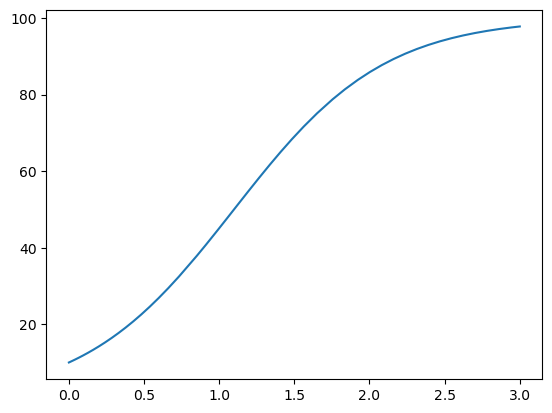

In [5]:
plt.plot(t_data,x_data)
plt.show()

### Solution method: Parameter sweep using scipy's ODEint

To solve this problem, we can sweep over different values of $\varepsilon$, using our model to produce results for each one. Then we'll compare these results to the true data and see which one reproduces the original data the closest.

In [46]:
def diffyqs(X, t, epsilon): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = epsilon*y*(100-y)
    return dydt

In [60]:
# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data

# range of values of epsiilon to sweep over
epsilons = np.arange(0.01,0.1,0.01)

#epsilons = [1/n for n in range(50,60)]

# empty list to store solutions
sols = []

In [62]:
# sweep over each value of epsilon and do numerical solution for each
for epsilon in epsilons:
    sols.append(odeint(diffyqs, x0_1, t, args=(epsilon,)))

Now that we have results, let's visualize them:

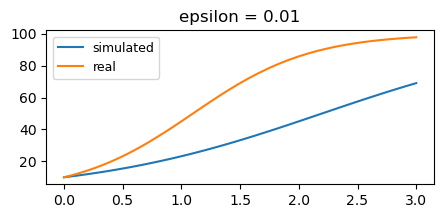

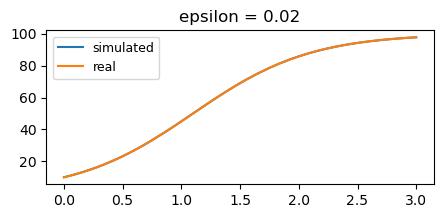

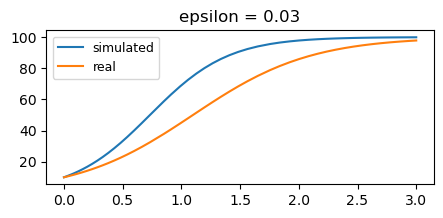

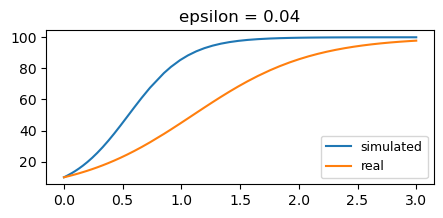

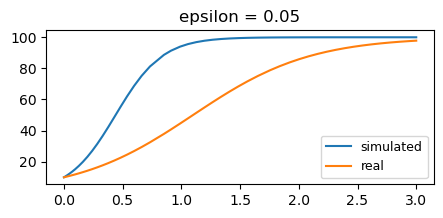

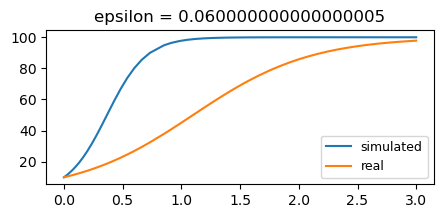

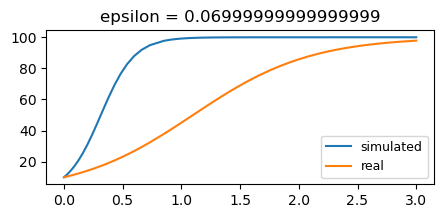

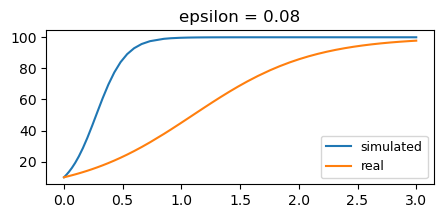

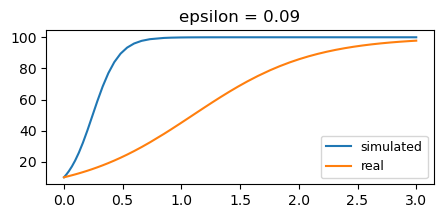

In [63]:
for i, sol in enumerate(sols):
    plt.figure(figsize = (5,2))
    plt.plot(t,sol.T[0], label = "simulated")
    plt.plot(t_data,x_data, label = 'real')
    plt.title('epsilon = ' + str(epsilons[i]))
    plt.legend(fontsize = 9)
    plt.show()

It looks like $\varepsilon = 1/50$ is a good choice. Let's write some code to be a bit more precise about this. We can add up the absolute value of the difference between the simulated and real trajectories to get the cumulative difference between them. The trajectory that minimizes this value will correspond to the best choice of $\varepsilon$

In [69]:
differences = []
for i, sol in enumerate(sols):
    differences.append(sum(np.abs(sol.T[0] - x_data)))

print("the best choice of epsilon is:", epsilons[np.argmin(differences)])

the best choice of epsilon is: 0.02


grace confirmed that this was the correct value =) Now Let's solve the problem again but with PyVBMC

# 

In [70]:
import scipy.stats as scs
from pyvbmc import VBMC

In [184]:
len(x_data)

48

In [192]:
def log_likelihood(theta):
    epsilon = theta
    sol = odeint(diffyqs, x0_1, t, args=(epsilon,)) # ??????
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

print(log_likelihood(0.02),log_likelihood(0.022), log_likelihood(0.015),log_likelihood(0.00083),log_likelihood(0.0007))

9.761120397747578e-11 567.6779872394596 5890.318452492012 135804.36548999214 136886.93552767864


In [193]:
D = 1  # We consider a 1-D problem


# def log_likelihood(theta):
#     """D-dimensional Rosenbrock's banana function."""
#     theta = np.atleast_2d(theta)

#     x, y = theta[:, :-1], theta[:, 1:]

    
#     return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)


# In general, `log_likelihood` would depend on the data and *your* particular model


prior_mu = np.zeros((1, D))
prior_std = 0.00001 * np.ones((1, D))


def log_prior(x):
    """Independent normal prior."""
    return np.sum(scs.norm.logpdf(x, prior_mu, prior_std))

def log_joint(x):
    """log-density of the joint distribution."""
    return log_likelihood(x) + log_prior(x)


LB = np.full((1, D), -10.0)  # Lower bounds
UB = np.full((1, D), 10.0)  # Upper bounds


PLB = prior_mu - prior_std  # Plausible lower bounds
PUB = prior_mu + prior_std  # Plausible upper bounds

# Alternatively, you could set the plausible bounds using the quantiles:
# PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
# PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)

x0 = 0.02 * np.ones((1, D)) #np.copy(prior_mu)

# Alternatively, we could use a random sample from inside the plausible box:
# x0 = PLB + np.random.uniform(size=(1,D))*(PUB - PLB)

vbmc = VBMC(log_joint, x0, LB, UB, PLB, PUB)

vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...


In [194]:
vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      154059.30      6586.78     89241.31        2        inf     start warm-up


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


     1         15      144863.04         0.00      1309.96        2        inf     
     2         20      144863.03         0.00         0.00        2      0.051     
     3         25      144863.04         0.00         0.00        2      0.133     
     4         30      144863.04         0.00         0.03        2      0.983     
     5         35      144863.03         0.00         0.07        2       2.23     
     6         40      144863.02         0.00         0.01        2       0.54     end warm-up
     7         45      144863.00         0.00         0.02        2      0.841     
     8         50      144862.97         0.00         0.01        2       0.59     
     9         55      144862.95         0.00         0.10        5       3.37     
    10         60      144862.71         0.00         0.24        5       8.84     
    11         65      144862.96         0.00         0.24        5       8.76     
    12         70      144863.00         0.00         0.12       

KeyboardInterrupt: 

In [180]:
#lml_true = -2.272  # ground truth, which we know for this toy scenario

#print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(results["elbo"], ".3f"))
print("The obtained ELBO_SD is:", format(results["elbo_sd"], ".3f"))

The obtained ELBO is: -139248.207
The obtained ELBO_SD is: 0.000


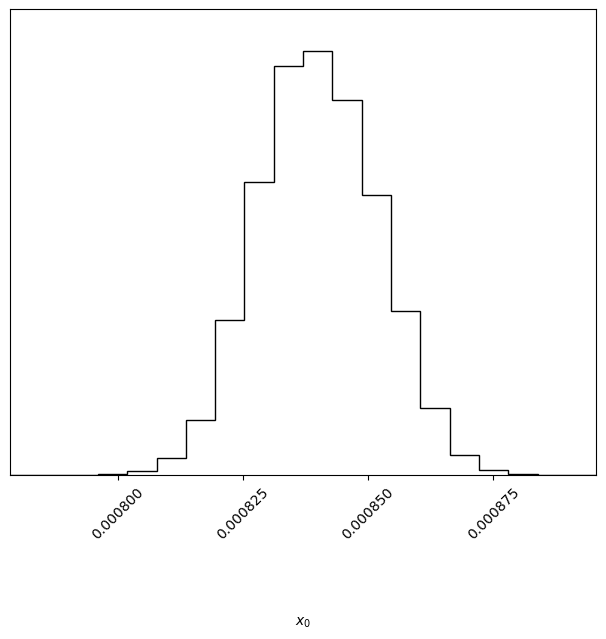

In [181]:
vp.plot();

In [182]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [0.00084]
The approximate posterior covariance matrix is:
 1.3600528280492724e-10


In [183]:
Xs.mean()

0.0008399987598743099